# Figs/Movie of SST/Surface Velocities/TCC

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt

In [2]:
#link = "gs://gcp-public-data-arco-era5/co/single-level-reanalysis.zarr-v2"
#link1 = "gs://gcp-public-data-arco-era5/co/single-level-reanalysis.zarr"
ex_link = "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2"

era5 = xr.open_zarr(ex_link, chunks={'time': 48},consolidated=True,)
#era = xr.open_zarr(link1, chunks={'time': 48},consolidated=True,)

In [3]:
era5

<xarray.Dataset> Size: 534TB
Dimensions:                                           (time: 552264,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 37)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 296B 1 .....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 4MB ...
Data variables: (12/31)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    geopotential                                      (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    ...                                                ...
    total_precipitation                               (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    type_of_high_vegetation                           (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    type_of_low_vegetation                            (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u_component_of_wind                               (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind                               (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>

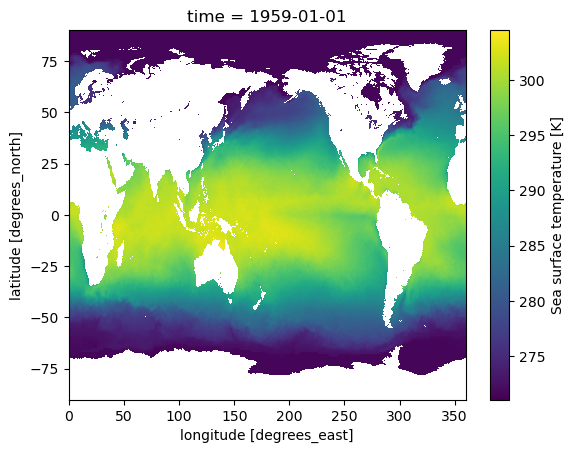

In [31]:
era5.sea_surface_temperature[0].plot()

In [4]:
#longitude = 98˚W to 81˚W
#360minus98, 360minus80
gom = dict(longitude=slice(262, 279), latitude=slice(31, 17.5))

#slice vars to GoM region
sst = era5.sea_surface_temperature.sel(**gom) - 273.15
tcc = era5.total_cloud_cover.sel(**gom)
gp = era5.geopotential.sel(**gom)
mslp = era5.mean_sea_level_pressure.sel(**gom)
mask = era5.land_sea_mask.sel(**gom)

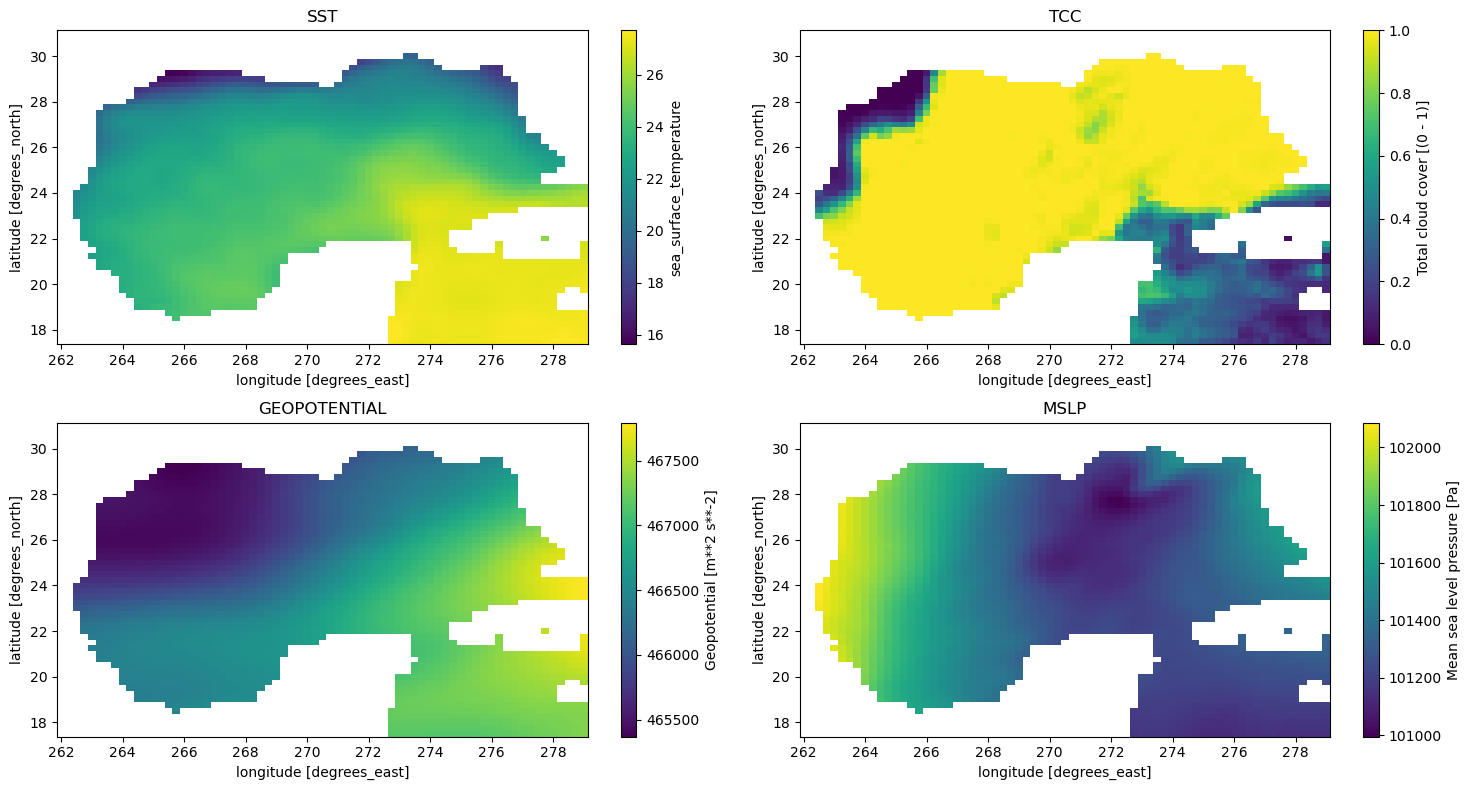

In [5]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
sst[0].where(mask==0).plot(ax=ax[0,0])
ax[0,0].set_title('SST')
tcc[0].where(mask==0).plot(ax=ax[0,1])
ax[0,1].set_title('TCC')
gp[0,0].where(mask==0).plot(ax=ax[1,0])
ax[1,0].set_title('GEOPOTENTIAL')
mslp[0].where(mask==0).plot(ax=ax[1,1])
ax[1,1].set_title('MSLP')
plt.tight_layout();

In [6]:
#Caluclate the anomalies of the vars
sst_anom = sst.groupby('time.dayofyear') - sst.groupby('time.dayofyear').mean('time')
tcc_anom = tcc.groupby('time.dayofyear') - tcc.groupby('time.dayofyear').mean('time')
gp_anom = gp.groupby('time.dayofyear') - gp.groupby('time.dayofyear').mean('time')
mslp_anom = mslp.groupby('time.dayofyear') - mslp.groupby('time.dayofyear').mean('time')

In [2]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(10)
client = cluster.get_client()

ValueError: No dask-gateway address provided or found in configuration

KeyboardInterrupt: 

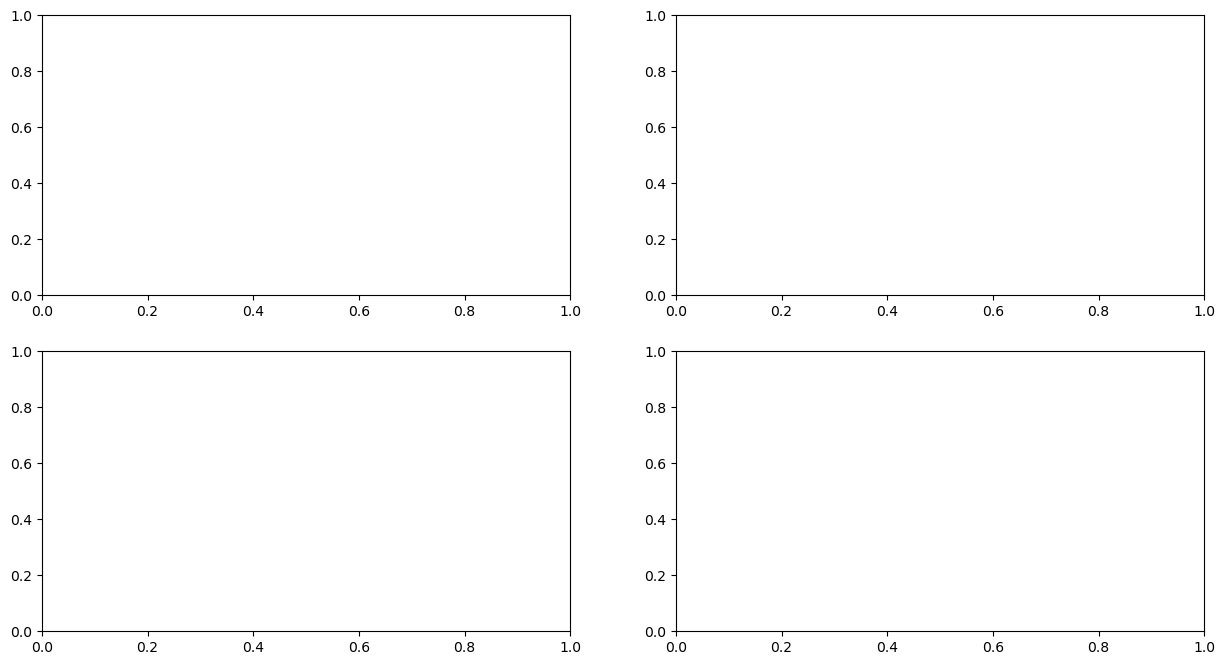

In [12]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
sst_anom.mean('time').where(mask==0).plot(ax=ax[0,0])
ax[0,0].set_title('SST')
tcc_anom.mean('time').where(mask==0).plot(ax=ax[0,1])
ax[0,1].set_title('TCC')
gp_anom.mean('time')[0].where(mask==0).plot(ax=ax[1,0])
ax[1,0].set_title('GEOPOTENTIAL')
mslp_anom.mean('time').where(mask==0).plot(ax=ax[1,1])
ax[1,1].set_title('MSLP')
plt.suptitle('Anomalous')
plt.tight_layout();

## Calculate trends

In [11]:
from scipy.stats import linregress

In [12]:
#linear regression at every grid cell over time, so that we see trend rate at each grid pt
# Calculate the linear trend at each grid point
trend_sst = sst.groupby('time.year').mean('time').polyfit('year', deg=1) #˚C/yr
trend_tcc = tcc.groupby('time.year').mean('time').polyfit('year', deg=1) #˚C/yr
trend_gp = gp.groupby('time.year').mean('time').polyfit('year', deg=1)
trend_mslp = mslp.groupby('time.year').mean('time').polyfit('year', deg=1)

In [ ]:
#linear regression at every grid cell over time, so that we see trend rate at each grid pt
# Calculate the linear trend at each grid point
trend_anom_sst = sst_anom.groupby('time.year').mean('time').polyfit('year', deg=1) #˚C/yr
trend_anom_tcc = tcc_anom.groupby('time.year').mean('time').polyfit('year', deg=1) #˚C/yr
trend_anom_gp = gp_anom.groupby('time.year').mean('time').polyfit('year', deg=1)
trend_anom_mslp = mslp_anom.groupby('time.year').mean('time').polyfit('year', deg=1)

## Trend maps

In [9]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

KeyboardInterrupt: 

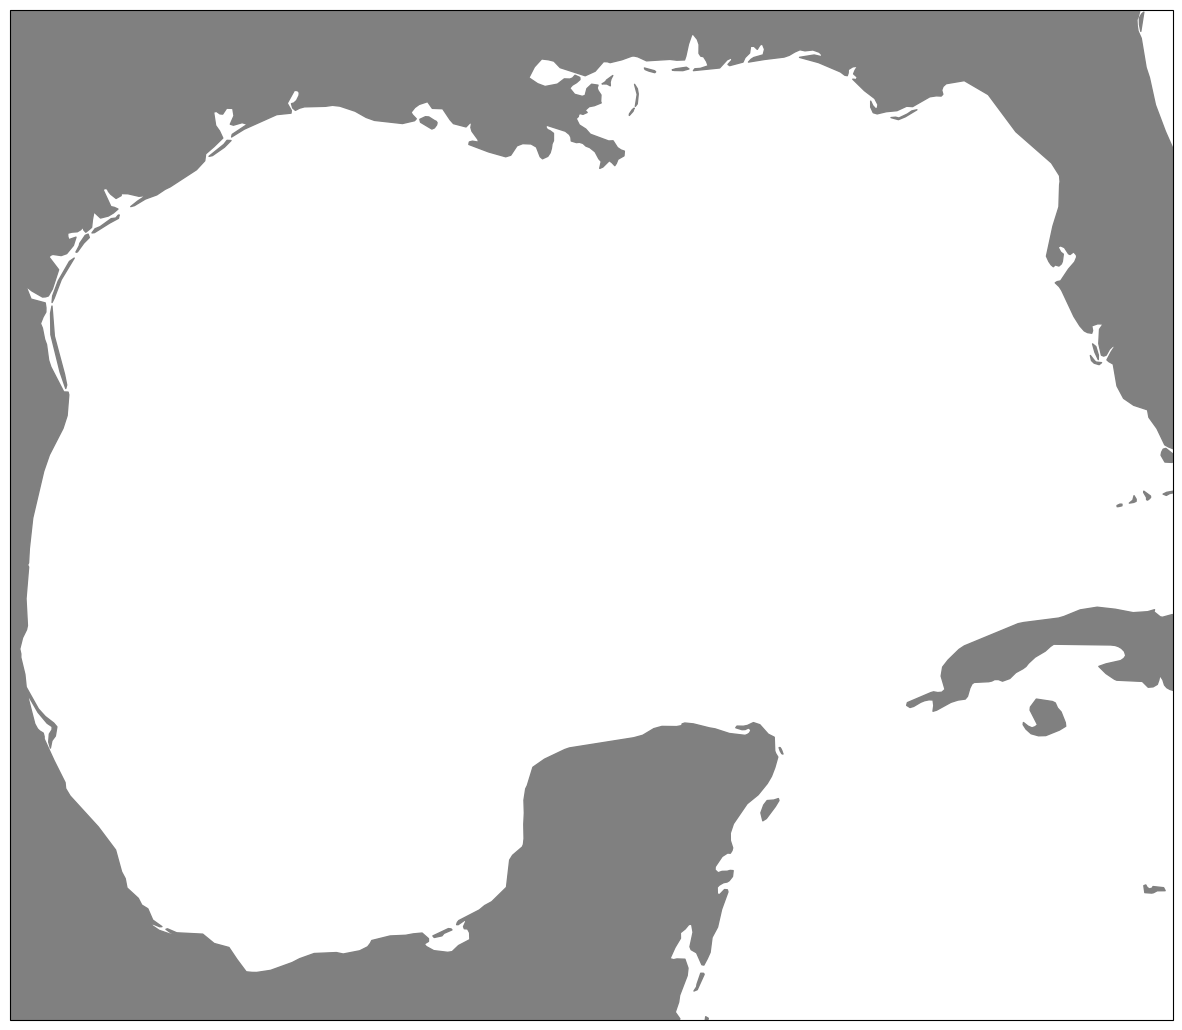

In [10]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
da = trend.polyfit_coefficients[0]
im = ax.pcolormesh(da.longitude, da.latitude, da, transform=ccrs.PlateCarree(), 
                   cmap='Spectral_r', vmin=-0.01, vmax=0.05)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Temperature trend (˚C yr $^{-1}$)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('SST Warming Trend (1959-2021)', fontsize=26);

In [61]:
trend_line = (trend[0]*np.arange(0,341880) + trend[1])

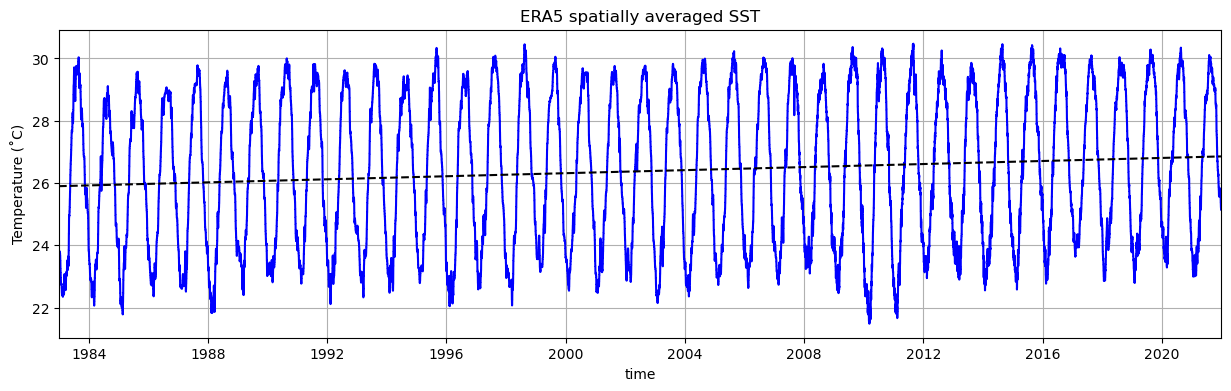

In [64]:
sst_feng.mean(['latitude', 'longitude']).plot(figsize=(15,4), color='blue')
plt.plot(sst_feng.time, trend_line, color='k', linestyle='dashed')
plt.grid()
plt.ylabel('Temperature (˚C)')
plt.xlim(sst_feng.time.sel(time='1983-01-01', method='nearest'), 
         sst_feng.time.sel(time='2021-12-31', method='nearest'))
plt.title('ERA5 spatially averaged SST');

In [68]:
print('Spatially averaged rate of SST increase over 1983-2021:', 
      (trend_line[-1] - trend_line[0]) / (2021-1983), 
      '˚C/yr')

Spatially averaged rate of SST increase over 1983-2021: 0.025146481519222164 ˚C/yr
